# **Sports Prediction and Betting Model**

We provide a walkthorugh for testing a model for prediction of sports outcomes, specifically on Major League Baseball data from 2021-2024 seasons.

**Outline of the contents:** In *Section 1*, we load the required packages as well as the data. (Much of the data gathering and cleaning was already covered in a separate notebook.) *Section 2* provides the required functions for projected score difference calculation and for updating the original odds and scores dataframe with them. *Section 3* has code for training a RandomForestClassifier model based on the features resulted by the PSD calculations, applying the model and outputting a brief assessment of its performance. *Section 4* gives a detailed analysis of the model's performance, including plots of cumulative profit, probability calibration and a breakdown of model's ROI based on odds ranges.

### **1- Preparations**

In [1]:
# Importing the required packages.
import os

import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, brier_score_loss, log_loss

from statistics import mean, stdev

Loading historical match data for Major League Basebal for the 2021, 2022, 2023 and 2024 seasons. 

In [2]:
# Loading historical data: needs path to MLB.xlsx
DF = pd.read_excel(os.path.join(os.getcwd(), "MLB", "Fixed", "MLB.xlsx"))
#DF = pd.read_excel("MLB.xlsx")

Two matches do not have scores and are removed.

In [3]:
DF[DF[["home_score", "away_score"]].isna().any(axis=1)]

,date,match_type,home_team,away_team,result,home_score,away_score,home_odds,away_odds
19,2024-10-31,play_off,Cleveland Guardians,Houston Astros,NaN,NaN,NaN,1.71,2.2
7670,2021-09-19,regular,Atlanta Braves,Colorado Rockies,NaN,NaN,NaN,1.58,2.5


In [4]:
DF = DF.dropna(subset=["home_score", "away_score"])

23 matches do not have odds. These will be used in our psd calculation, but will be removed before the betting analysis.

In [5]:
DF[DF[["home_odds", "away_odds"]].isna().any(axis=1)]

,date,match_type,home_team,away_team,result,home_score,away_score,home_odds,away_odds
450,2024-08-31,regular,Chicago White Sox,Texas Rangers,A,1.0,3.0,NaN,NaN
1516,2024-06-10,regular,Cleveland Guardians,Kansas City Royals,A,3.0,4.0,NaN,NaN
1669,2024-05-30,regular,St.Louis Cardinals,Chicago Cubs,H,7.0,6.0,NaN,NaN
1716,2024-05-26,regular,St.Louis Cardinals,Baltimore Orioles,H,3.0,1.0,NaN,NaN
2508,2023-11-02,play_off,New York Mets,Miami Marlins,H,1.0,0.0,NaN,NaN
2567,2023-10-02,regular,New York Mets,Philadelphia Phillies,H,11.0,4.0,NaN,NaN
3545,2023-07-19,regular,St.Louis Cardinals,Washington Nationals,A,5.0,7.0,NaN,NaN
3558,2023-07-19,regular,Cincinnati Reds,San Francisco Giants,A,2.0,4.0,NaN,NaN
4227,2023-05-24,regular,New York Mets,Cleveland Guardians,H,5.0,4.0,NaN,NaN
4346,2023-05-16,regular,Washington Nationals,New York Mets,H,3.0,2.0,NaN,NaN


### **2- Projected score difference calculation**

The following function inputs home and away team names, the match date and its provided format and outputs the *projected score difference* as home/away teams based on the performance in the search window, the length of which is inputted as search_length (in months). The other input is a properly formatted dataframe containing the corresponding historical match data.

In [6]:
def calculate_projected_score_difference(home_team, away_team, match_date, 
                                          date_format="mixed", search_length=12, dataframe=None):
    """
    Calculates projected score difference between two teams based on matches played against common opponents.

    Parameters:
        home_team (str): Name of the home team.
        away_team (str): Name of the away team.
        match_date (str): Date of the match.
        date_format (str): Format of the date strings in the dataframe. Defaults to "mixed".
        search_length (int): Number of months prior to the match_date to consider.
        dataframe (pd.DataFrame): Dataframe containing match data with required columns.

    Returns:
        dict: Dictionary containing statistics for projected score differences as home and away teams.
    """
    try:
        # Validate inputs
        if dataframe is None or not isinstance(dataframe, pd.DataFrame):
            raise ValueError("Input dataframe is invalid or not provided.")
        
        required_columns = {"date", "home_team", "away_team", "result", "home_score", "away_score"}
        if not required_columns.issubset(dataframe.columns):
            raise ValueError(f"Dataframe must contain the following columns: {required_columns}")

        # Convert dates
        if date_format == "mixed":
            dataframe["formatted_date"] = pd.to_datetime(dataframe["date"], errors='coerce')
            match_date = pd.to_datetime(match_date, errors='coerce')
        else:
            dataframe["formatted_date"] = pd.to_datetime(dataframe["date"], format=date_format, errors='coerce')
            match_date = pd.to_datetime(match_date, format=date_format, errors='coerce')

        if pd.isnull(match_date):
            raise ValueError("match_date could not be converted to a valid date.")

        # Filter dataframe for matches within the search length
        search_start_date = match_date - DateOffset(months=search_length)
        filtered_df = dataframe[(dataframe["formatted_date"] >= search_start_date) &
                                 (dataframe["formatted_date"] < match_date)]

        # Filter matches for each team's history
        home_team_home_matches = filtered_df[filtered_df["home_team"] == home_team]
        away_team_away_matches = filtered_df[filtered_df["away_team"] == away_team]
        home_team_away_matches = filtered_df[filtered_df["away_team"] == home_team]
        away_team_home_matches = filtered_df[filtered_df["home_team"] == away_team]

        # Combine matches for overall history
        home_team_matches = pd.concat([home_team_home_matches, home_team_away_matches], ignore_index=True)
        away_team_matches = pd.concat([away_team_away_matches, away_team_home_matches], ignore_index=True)

        # Find common opponents
        home_opponents = set(home_team_home_matches["away_team"]) | set(home_team_away_matches["home_team"])
        away_opponents = set(away_team_home_matches["away_team"]) | set(away_team_away_matches["home_team"])
        common_opponents = list(home_opponents.intersection(away_opponents))

        # Initialise lists for projected score differences
        diff_list = []
        diff_list2 = []

        for opponent in common_opponents:
            # Matches where teams played the common opponent
            home_vs_opponent_home = home_team_matches[home_team_matches["away_team"] == opponent]
            away_vs_opponent_home = away_team_matches[away_team_matches["away_team"] == opponent]
            home_vs_opponent_away = home_team_matches[home_team_matches["home_team"] == opponent]
            away_vs_opponent_away = away_team_matches[away_team_matches["home_team"] == opponent]

            # Score differences
            home_diff1 = (home_vs_opponent_home["home_score"] - home_vs_opponent_home["away_score"]).tolist()
            away_diff1 = (away_vs_opponent_home["home_score"] - away_vs_opponent_home["away_score"]).tolist()

            home_diff2 = (home_vs_opponent_away["away_score"] - home_vs_opponent_away["home_score"]).tolist()
            away_diff2 = (away_vs_opponent_away["away_score"] - away_vs_opponent_away["home_score"]).tolist()

            # Calculate projected score differences
            if home_diff1 and away_diff1:
                psd_home = (len(away_diff1) * sum(home_diff1) - len(home_diff1) * sum(away_diff1)) / \
                           (len(away_diff1) * len(home_diff1))
                diff_list.append(psd_home)

            if home_diff2 and away_diff2:
                psd_away = (len(away_diff2) * sum(home_diff2) - len(home_diff2) * sum(away_diff2)) / \
                           (len(away_diff2) * len(home_diff2))
                diff_list2.append(psd_away)

        # Calculate final statistics
        psdh = mean(diff_list) if diff_list else 0
        psda = mean(diff_list2) if diff_list2 else 0

        len_diff_list = len(diff_list)
        len_diff_list2 = len(diff_list2)

        std_diff_list = stdev(diff_list) if len(diff_list) > 1 else 0
        std_diff_list2 = stdev(diff_list2) if len(diff_list2) > 1 else 0

        return {
            "projected_score_difference_as_home": {
                "mean": psdh,
                "std": std_diff_list,
                "count": len_diff_list
            },
            "projected_score_difference_as_away": {
                "mean": psda,
                "std": std_diff_list2,
                "count": len_diff_list2
            }
        }

    except Exception as e:
        raise RuntimeError(f"An error occurred while calculating the projected score difference: {e}")


The following function uses the above to add the *projected score difference* statistics to the portion of a dataframe within a prescribed date range.

In [7]:
def add_projected_score_statistics(dataframe, start_date, end_date, date_format="mixed", search_length = 12):
    """
    Adds projected score difference statistics to a new dataframe for matches within a timeframe.

    Parameters:
        dataframe (pd.DataFrame): Historical match data with required columns.
        start_date (str): Start date of the analysis range.
        end_date (str): End date of the analysis range.
        search_length (int): Number of months prior to each match date to consider for statistics.

    Returns:
        pd.DataFrame: New dataframe with matches in the specified range and additional columns for projected score difference statistics.
    """
    try:
        # Validate inputs
        if not isinstance(dataframe, pd.DataFrame):
            raise ValueError("Input dataframe is invalid or not provided.")
        
        required_columns = {"date", "home_team", "away_team", "home_score", "away_score"}
        if not required_columns.issubset(dataframe.columns):
            raise ValueError(f"Dataframe must contain the following columns: {required_columns}")

        # Convert dates
        dataframe["formatted_date"] = pd.to_datetime(dataframe["date"], errors='coerce')
        start_date = pd.to_datetime(start_date, errors='coerce')
        end_date = pd.to_datetime(end_date, errors='coerce')

        if pd.isnull(start_date) or pd.isnull(end_date):
            raise ValueError("start_date or end_date could not be converted to valid dates.")

        if start_date >= end_date:
            raise ValueError("start_date must be earlier than end_date.")

        # Remove invalid score entries
        dataframe = dataframe[dataframe["home_score"].apply(lambda x: isinstance(x, float))]
        dataframe = dataframe[dataframe["away_score"].apply(lambda x: isinstance(x, float))]

        # Filter dataframe for the extended range
        extended_start_date = start_date - DateOffset(months=search_length)
        filtered_df = dataframe[(dataframe["formatted_date"] >= extended_start_date) &
                                 (dataframe["formatted_date"] <= end_date)].copy()

        # Filter for matches in the specified range
        analysis_df = filtered_df[(filtered_df["formatted_date"] >= start_date) &
                                   (filtered_df["formatted_date"] <= end_date)].copy()

        # Initialise columns for projected score statistics
        analysis_df["psd_home_mean"] = None
        analysis_df["psd_away_mean"] = None
        analysis_df["psd_home_std"] = None
        analysis_df["psd_away_std"] = None
        analysis_df["psd_home_count"] = None
        analysis_df["psd_away_count"] = None

        # Iterate through matches in the analysis range
        for index, row in analysis_df.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            match_date = row["formatted_date"]

            # Calculate projected score statistics
            stats = calculate_projected_score_difference(
                home_team=home_team,
                away_team=away_team,
                match_date=match_date,
                date_format=date_format,
                search_length=search_length,
                dataframe=filtered_df
            )

            # Add statistics to the analysis dataframe
            analysis_df.at[index, "psd_home_mean"] = stats["projected_score_difference_as_home"]["mean"]
            analysis_df.at[index, "psd_away_mean"] = stats["projected_score_difference_as_away"]["mean"]
            analysis_df.at[index, "psd_home_std"] = stats["projected_score_difference_as_home"]["std"]
            analysis_df.at[index, "psd_away_std"] = stats["projected_score_difference_as_away"]["std"]
            analysis_df.at[index, "psd_home_count"] = stats["projected_score_difference_as_home"]["count"]
            analysis_df.at[index, "psd_away_count"] = stats["projected_score_difference_as_away"]["count"]

        # Sort by date in descending order and reset index
        analysis_df.sort_values(by="formatted_date", ascending=False, inplace=True)
        analysis_df.reset_index(drop=True, inplace=True)

        return analysis_df

    except Exception as e:
        raise RuntimeError(f"An error occurred while adding projected score statistics: {e}")

We add the projected statistics to the 2022, 2023 and 2024 seasons (2021 season is used only to evaluate the 2022 projected score difference statistics). This can take 10 or more minutes.

In [8]:
DF_with_projected_score_statistics = add_projected_score_statistics(DF, '2022-01-01', '2024-12-30', "mixed", 12)

In [9]:
# Good to keep a copy of this.
DF_with_projected_score_statistics_copy = DF_with_projected_score_statistics.copy()

### **3- Machine learning: RandomForestClassifier**

The following trains a RandomForestClassifier on a prescribed earlier portion of an input dataset, to determine and record win probabilities of teams for each match in the test set. It then uses the given odds and the Kelly criterion to place bets and record the net profit. It outputs the model, the resulting prediction/betting dataframe, the accuracy and a general report on the model's performance.

In [10]:
# kelly inputs the odds of an event and its preceived probability
# outputs a decimal corresponding to the fraction of one's capital, one should bet
def kelly(odds, prob):
    if odds <= 1:
        return 0
    return max(0, prob - (1 - prob) / (odds - 1))

def train_and_predict_psd_model(dataframe, test_size=0.6):
    """
    Trains a machine learning model to predict match results (home win or away win) based on PSD values and their reliability,
    and calculates betting strategy and profit based on predicted probabilities.

    Parameters:
        dataframe (pd.DataFrame): Input dataframe with necessary columns.
        test_size (float): Proportion of the dataset to include in the test split.

    Returns:
        dict: Dictionary containing the trained model, prediction dataframe, and performance metrics.
    """
    # Sort the dataframe by date to ensure proper temporal ordering
    dataframe = dataframe.sort_values(by="formatted_date").reset_index(drop=True)

    # Determine split index based on test size
    split_index = int(len(dataframe) * (1 - test_size))

    # Split data into training and testing sets
    train_df = dataframe.iloc[:split_index]
    test_df = dataframe.iloc[split_index:].copy()

    # Define features and target
    features = ["psd_home_mean", "psd_away_mean", "psd_home_std", "psd_away_std"]
    X_train = train_df[features]
    y_train = (train_df["result"] == "H").astype(int)  # 1 for home win, 0 for away win
    X_test = test_df[features]
    y_test = (test_df["result"] == "H").astype(int)

    # Train a RandomForestClassifier (can be replaced with other models)
    model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for home win

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["Away Win", "Home Win"], output_dict=True)

    # Add predictions and probabilities to the test dataframe
    test_df.loc[:, "predicted_result"] = ["H" if pred == 1 else "A" for pred in y_pred]
    test_df.loc[:, "home_win_probability"] = y_pred_proba
    test_df.loc[:, "away_win_probability"] = 1 - y_pred_proba

    # Initialise betting columns
    test_df.loc[:, "home_bet"] = 0.0
    test_df.loc[:, "away_bet"] = 0.0
    test_df.loc[:, "profit"] = 0.0

    # Calculate bets and profit for each match in the test set
    for index, row in test_df.iterrows():
        try:
            home_odds = row["home_odds"]
            away_odds = row["away_odds"]
            home_win_prob = row["home_win_probability"]
            away_win_prob = row["away_win_probability"]

            # Calculate bets using Kelly criterion
            home_bet = kelly(home_odds, home_win_prob)
            away_bet = kelly(away_odds, away_win_prob)

            # Calculate profit
            profit = 0
            if row["result"] == "H":
                profit = home_bet * (home_odds - 1) - away_bet
            elif row["result"] == "A":
                profit = away_bet * (away_odds - 1) - home_bet

            # Update test dataframe
            test_df.loc[index, "home_bet"] = home_bet
            test_df.loc[index, "away_bet"] = away_bet
            test_df.loc[index, "profit"] = profit

        except Exception as e:
            print(f"Error processing row {index}: {e}")

    # Return the model, predictions, and metrics
    return {
        "model": model,
        "prediction_dataframe": test_df,
        "accuracy": accuracy,
        "classification_report": report
    }

We now drop matches with no provided odds, before applying the betting strategy.

In [11]:
DF_with_projected_score_statistics = DF_with_projected_score_statistics.dropna(subset=["home_odds", "away_odds"])

We also need to remove matches with no projected score differences and we have 16 of them.

In [12]:
len(DF_with_projected_score_statistics[(DF_with_projected_score_statistics["psd_home_count"] == 0) | (DF_with_projected_score_statistics["psd_away_count"] == 0)])

16

In [13]:
DF_with_projected_score_statistics = DF_with_projected_score_statistics[(DF_with_projected_score_statistics["psd_home_count"] != 0) & (DF_with_projected_score_statistics["psd_away_count"] != 0)]

In [14]:
# Resetting indices.
DF_with_projected_score_statistics.reset_index(inplace=True)

Applying the model and fetching key performance metrics.

In [15]:
model_performance_dict = train_and_predict_psd_model(DF_with_projected_score_statistics, 0.6)

In [16]:
# Total profit
model_performance_dict["prediction_dataframe"]['profit'].sum()

7.294574577161278

In [17]:
model_performance_dict['accuracy']

0.5581132927104491

In [18]:
model_performance_dict['classification_report']

{'Away Win': {'precision': 0.5492874109263658,
  'recall': 0.4354990583804143,
  'f1-score': 0.48581932773109243,
  'support': 2124.0},
 'Home Win': {'precision': 0.5635238441936659,
  'recall': 0.6710013003901171,
  'f1-score': 0.6125840918084685,
  'support': 2307.0},
 'accuracy': 0.5581132927104491,
 'macro avg': {'precision': 0.5564056275600158,
  'recall': 0.5532501793852657,
  'f1-score': 0.5492017097697804,
  'support': 4431.0},
 'weighted avg': {'precision': 0.556699609425048,
  'recall': 0.5581132927104491,
  'f1-score': 0.5518193978566863,
  'support': 4431.0}}

### **4- In-depth analysis of model's performance**

In [19]:
# Fetching our predictions and betting dataframe.
prediction_dataframe = model_performance_dict['prediction_dataframe']

The following evaluates various metrics corresponding to the efficacy of both our model and bookmaker concensus in predicting match outcomes.

In [20]:
def analyse_prediction_performance(df):
    """
    Analyse model performance and compare it to bookmaker probabilities.

    Parameters:
        df (pd.DataFrame): Dataframe containing prediction results and betting details.

    Returns:
        dict: Dictionary with various performance metrics and insights.
    """
    results = {}

    # Calculate implied probabilities from bookmaker odds
    df["implied_bookmakers_home_prob"] = 1 / df["home_odds"] / (
        1 / df["home_odds"] + 1 / df["away_odds"]
    )
    df["implied_bookmakers_away_prob"] = 1 - df["implied_bookmakers_home_prob"]

    # Model accuracy
    df["correct_prediction"] = df["result"] == df["predicted_result"]
    accuracy = df["correct_prediction"].mean()
    results["model_accuracy"] = accuracy

    # Bookmaker accuracy
    df["bookmaker_prediction"] = np.where(
        df["implied_bookmakers_home_prob"] > df["implied_bookmakers_away_prob"], "H", "A"
    )
    df["correct_bookmaker_prediction"] = df["result"] == df["bookmaker_prediction"]
    bookmaker_accuracy = df["correct_bookmaker_prediction"].mean()
    results["bookmaker_accuracy"] = bookmaker_accuracy

    # Baseline: home win percentage
    home_win_percentage = (df["result"] == "H").mean()
    results["home_win_percentage"] = home_win_percentage

    # Brier score for model and bookmakers
    brier_model = brier_score_loss((df["result"] == "H").astype(int), df["home_win_probability"])
    brier_bookmaker = brier_score_loss((df["result"] == "H").astype(int), df["implied_bookmakers_home_prob"])
    results["brier_score_model"] = brier_model
    results["brier_score_bookmaker"] = brier_bookmaker

    # Log-loss for model and bookmakers
    logloss_model = log_loss((df["result"] == "H").astype(int), df["home_win_probability"])
    logloss_bookmaker = log_loss((df["result"] == "H").astype(int), df["implied_bookmakers_home_prob"])
    results["log_loss_model"] = logloss_model
    results["log_loss_bookmaker"] = logloss_bookmaker

    # Profit and ROI
    total_profit = df["profit"].sum()
    total_bets = df["home_bet"].sum() + df["away_bet"].sum()
    roi = (total_profit / total_bets) * 100 if total_bets > 0 else 0
    results["total_profit"] = total_profit
    results["roi"] = roi

    # Additional metrics
    results["total_matches"] = len(df)
    results["matches_bet_on"] = len(df) - len(df[df['profit']==0])
    results["total_bets"] = total_bets
#    results["average_bet_size"] = total_bets / len(df) if len(df) > 0 else 0 # Depends on how you look at it.
    results["average_bet_size"] = total_bets / results["matches_bet_on"] if results["matches_bet_on"] > 0 else 0
    results["profitable_bets"] = (df["profit"] > 0).sum()
#    results["profitable_bets_percentage"] = (results["profitable_bets"] / len(df)) * 100 # Depends on how you look at it.
    results["profitable_bets_percentage"] = (results["profitable_bets"] / results["matches_bet_on"]) * 100

    return results

In [21]:
# Usage
analyse_prediction_performance(prediction_dataframe)

{'model_accuracy': 0.5581132927104491,
 'bookmaker_accuracy': 0.5716542541187091,
 'home_win_percentage': 0.5206499661475965,
 'brier_score_model': 0.24515332859404648,
 'brier_score_bookmaker': 0.24190463153806918,
 'log_loss_model': 0.6834340059423553,
 'log_loss_bookmaker': 0.6766407563136515,
 'total_profit': 7.294574577161278,
 'roi': 1.949315404504727,
 'total_matches': 4431,
 'matches_bet_on': 3632,
 'total_bets': 374.2121239233037,
 'average_bet_size': 0.10303197244584353,
 'profitable_bets': 1667,
 'profitable_bets_percentage': 45.897577092511014}

For 799 out of 4431 available matches, the model did not place a bet on either side. This happens exactly when bookmakers' consensus aligns tightly with the model's prediction and thus Kelly's criterion does not find value in betting on either side (in large part, also because of the "house edge").

It is worth noting that both our model and the bookmakers maintained about the same accuracy for the matches, on which we placed a bet.

In [23]:
prediction_dataframe_matches_considered = prediction_dataframe[prediction_dataframe["profit"] !=0]

In [24]:
prediction_dataframe_matches_considered["correct_prediction"].mean()

0.5583700440528634

In [25]:
prediction_dataframe_matches_considered["correct_bookmaker_prediction"].mean()

0.575715859030837

**Plotting the cumulative profit of the model**

In [26]:
def plot_cumulative_profit(df):
    """
    Plots the cumulative profit of the model.

    Parameters:
        df (pd.DataFrame): Dataframe containing prediction results and profit column.

    Returns:
        None: Displays the cumulative profit plot.
    """
    # Reverse the dataframe for chronological order if needed
    df_reversed = df.iloc[::-1].reset_index(drop=True)

    # Calculate cumulative profit
    df_reversed["Cumulative_Profit"] = df_reversed["profit"].cumsum()

    # Plot cumulative profit
    plt.figure(figsize=(10, 6))
    plt.plot(df_reversed.index, df_reversed["Cumulative_Profit"], label="Cumulative Profit", linewidth=2)
    plt.xlabel("Match")
    plt.ylabel("Cumulative Profit")
    plt.title("Cumulative Profit of the Model")
    plt.grid(True)
    plt.legend()
    plt.show()
#    plt.savefig('cumulative_profit.png')

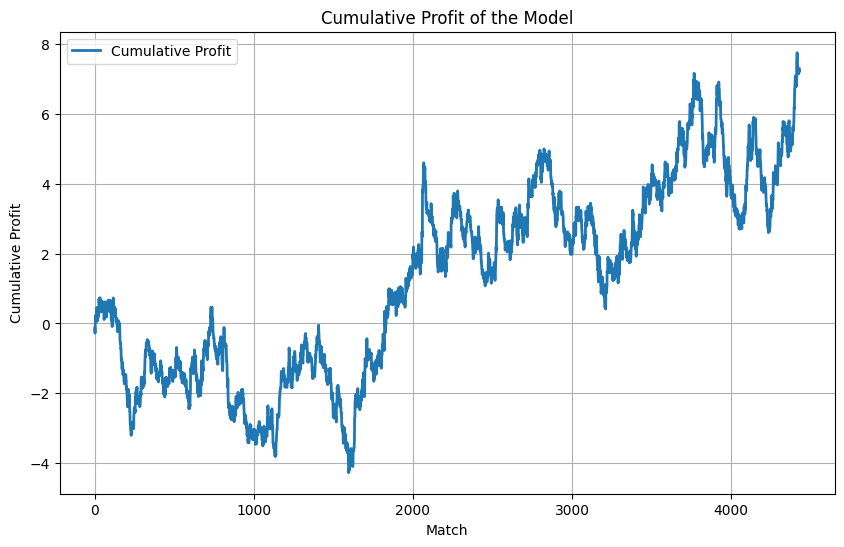

In [27]:
# Usage
plot_cumulative_profit(prediction_dataframe)

**Breaking down ROI by odds ranges** revealing possible overconfidence in clear underdogs. 

In [28]:
def analyse_roi_by_odds_range(df):
    """
    Analyses ROI by odds range and prints results.

    Parameters:
        df (pd.DataFrame): Dataframe containing odds and profit columns.

    Returns:
        pd.DataFrame: Summary table of ROI by odds range.
    """
    bins = [1.0, 1.5, 2.0, 3.0, 5.0, 10.0, 100.0]
    labels = ["1-1.5", "1.5-2", "2-3", "3-5", "5-10", "10+"]
    df["odds_range"] = pd.cut(df["home_odds"], bins=bins, labels=labels, right=False)

    roi_summary = df.groupby("odds_range", observed=True).apply(
        lambda x: pd.Series({
            "total_bets": x["home_bet"].sum() + x["away_bet"].sum(),
            "total_profit": x["profit"].sum(),
            "roi": (x["profit"].sum() / (x["home_bet"].sum() + x["away_bet"].sum()) * 100)
            if (x["home_bet"].sum() + x["away_bet"].sum()) > 0 else 0
        })
    ).reset_index()

    print("ROI by Odds Range:")
    print(roi_summary)
    return roi_summary

In [29]:
# Usage
roi_by_odds = analyse_roi_by_odds_range(prediction_dataframe)

ROI by Odds Range:
  odds_range  total_bets  total_profit       roi
0      1-1.5   49.041573     -3.076164 -6.272564
1      1.5-2  209.875752      5.519636  2.629954
2        2-3  108.459558      4.420650  4.075851
3        3-5    6.835241      0.430452  6.297545


**Plotting calibration curve for the model** again revealing inaccuracies for uneven matchups. 

In [30]:
def plot_calibration_curve(df):
    """
    Plots the calibration curve for the model.

    Parameters:
        df (pd.DataFrame): Dataframe containing prediction probabilities and actual results.

    Returns:
        None: Displays the calibration curve plot.
    """
    df["prediction_bin"] = pd.cut(df["home_win_probability"], bins=np.linspace(0, 1, 11), include_lowest=True)
    calibration = df.groupby("prediction_bin", observed=True).apply(
        lambda x: pd.Series({
            "mean_predicted": x["home_win_probability"].mean(),
            "actual_win_rate": (x["result"] == "H").mean()
        })
    ).dropna()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration["mean_predicted"], calibration["actual_win_rate"], marker="o", label="Model")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
    plt.xlabel("Predicted Win Probability")
    plt.ylabel("Actual Win Rate")
    plt.title("Calibration Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
#    plt.savefig('calibration_curve.png')

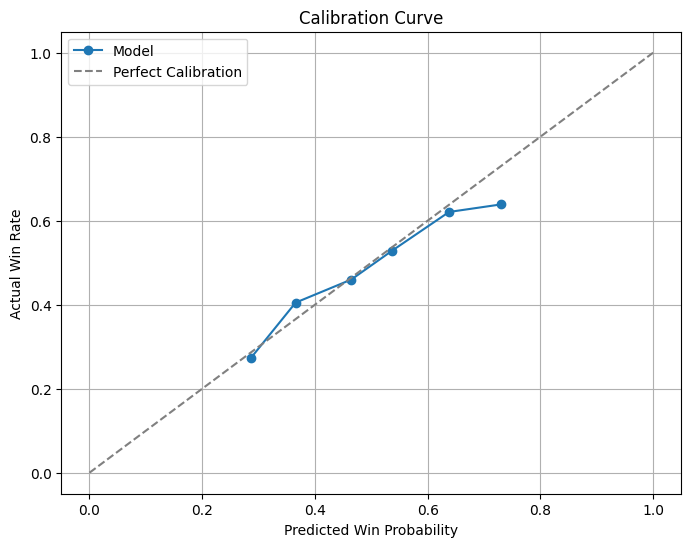

In [31]:
# Usage
plot_calibration_curve(prediction_dataframe)

Note that the above analysis provides strong clues on how to calibrate or otherwise improve performance of the model, assuming this is indeed a persistent pattern on a larger scale. E.g. one could simply not place any bets when the model recommends betting on clear favourites.

Given the somewhat periodic patterns in the cumulative profit plot, it is inviting to break down ROI by months (year_months). Based on the analysis, I do not see a clear pattern.

In [32]:
def analyse_roi_by_month(df):
    """
    Analyses ROI by month and prints results.

    Parameters:
        df (pd.DataFrame): Dataframe containing date and profit columns.

    Returns:
        pd.DataFrame: Summary table of ROI by month.
    """
    # Ensure the formatted_date column is in datetime format
    df["formatted_date"] = pd.to_datetime(df["formatted_date"])

    # Extract the month and year from the formatted_date column
    df["month_year"] = df["formatted_date"].dt.to_period("M")

    roi_summary = df.groupby("month_year", observed=True).apply(
        lambda x: pd.Series({
            "total_bets": x["home_bet"].sum() + x["away_bet"].sum(),
            "total_profit": x["profit"].sum(),
            "roi": (x["profit"].sum() / (x["home_bet"].sum() + x["away_bet"].sum()) * 100)
            if (x["home_bet"].sum() + x["away_bet"].sum()) > 0 else 0
        })
    ).reset_index()

    print("ROI by Month:")
    print(roi_summary)
    return roi_summary

In [33]:
# Usage
roi_by_month = analyse_roi_by_month(prediction_dataframe)

ROI by Month:
   month_year  total_bets  total_profit        roi
0     2023-05   31.223414      3.182466  10.192562
1     2023-06   35.967555     -2.177829  -6.054981
2     2023-07   35.459859      4.378042  12.346472
3     2023-08   35.023168     -0.813305  -2.322193
4     2023-09   31.452891     -0.277326  -0.881718
5     2023-10    4.697263      1.533088  32.637896
6     2023-11    3.603792      0.370648  10.284948
7     2024-03    1.597635     -0.563340 -35.260887
8     2024-04   34.484097      0.056223   0.163039
9     2024-05   36.205717      3.903088  10.780309
10    2024-06   31.833824     -0.863826  -2.713546
11    2024-07   23.874466      0.926901   3.882395
12    2024-08   36.713052     -0.735690  -2.003891
13    2024-09   28.332207     -2.115323  -7.466143
14    2024-10    3.743184      0.490758  13.110705


Also by calendar months.

In [34]:
def analyse_roi_by_month_only(df):
    """
    Analyses ROI by calendar month (ignoring year) and prints results.

    Parameters:
        df (pd.DataFrame): Dataframe containing date and profit columns.

    Returns:
        pd.DataFrame: Summary table of ROI by calendar month.
    """
    # Ensure the formatted_date column is in datetime format
    df["formatted_date"] = pd.to_datetime(df["formatted_date"])

    # Extract the month from the formatted_date column
    df["month"] = df["formatted_date"].dt.month

    roi_summary = df.groupby("month", observed=True).apply(
        lambda x: pd.Series({
            "total_bets": x["home_bet"].sum() + x["away_bet"].sum(),
            "total_profit": x["profit"].sum(),
            "roi": (x["profit"].sum() / (x["home_bet"].sum() + x["away_bet"].sum()) * 100)
            if (x["home_bet"].sum() + x["away_bet"].sum()) > 0 else 0
        })
    ).reset_index()

    print("ROI by Calendar Month:")
    print(roi_summary)
    return roi_summary

In [35]:
# Usage
roi_by_calendar_month = analyse_roi_by_month_only(prediction_dataframe)

ROI by Calendar Month:
   month  total_bets  total_profit        roi
0      3    1.597635     -0.563340 -35.260887
1      4   34.484097      0.056223   0.163039
2      5   67.429131      7.085554  10.508150
3      6   67.801378     -3.041654  -4.486124
4      7   59.334325      5.304943   8.940765
5      8   71.736220     -1.548995  -2.159293
6      9   59.785098     -2.392649  -4.002082
7     10    8.440447      2.023846  23.977943
8     11    3.603792      0.370648  10.284948
